Custom ResNet18 Model

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision

Set data directory, wanted batch size and the number of epochs for the training process

In [21]:
dataDir = "Dataset"
batchSize = 16
numEpochs = 5

Try to utilizes CUDA-cores for training, otherwise the CPU will be used. The path for the model is also determined

In [22]:
modelPath = "resnet18_custom.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The imagetransformation is defined and the images will be resized to 224x224, as ResNet18 was trained on that size.

In [23]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [24]:
train_dataset = datasets.ImageFolder(os.path.join(dataDir, "train"), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(dataDir, "val"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batchSize, shuffle=False)

num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)

Classes: ['Machine', 'Philips', 'Plaster', 'Torx']


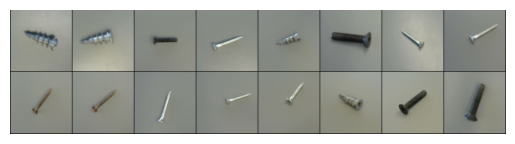

Plaster Plaster Machine Torx  Plaster Machine Torx  Torx  Philips Philips Torx  Torx  Torx  Plaster Machine Machine


In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get some random training images from your custom dataset
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images as a grid
imshow(torchvision.utils.make_grid(images))